In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.support.ui import Select
import matplotlib.colors as mcl

In [2]:
data = pd.read_csv('C:/Users/HEESU/[opgg데이터분석가]/11.23.csv',index_col = 0, nrows = 1000000)
champStat = pd.read_csv('C:/Users/HEESU/[opgg데이터분석가]/champ_stats.csv',index_col=0)

In [3]:
tierPoint = {'I':0 , 'B':400, 'S':800, 'G':1200, 'P':1600, 'D':2000, 'M':2400, 'R':2800, 'C':3200}
inv_tierPoint = {0:'I',  1:'B', 2:'S', 3:'G', 4:'P', 5:'D', 6:'M', 7:'R', 8:'C'}

In [4]:
# 배치고사를 치는 유저는 나머지 유저들의 평균 티어를 계산하여 그 티어로 배정.(mmr계산)

def get_meanTier(gameId):
    
    summonerRank = data[data['gameId']==gameId]['tierRank']
    cnt = 0
    pointSum = 0
    
    for tier in summonerRank:
        try:
            pointSum += tierPoint[tier[0]]
            pointSum += (4-int(tier[1]))*100
            cnt += 1
        except:
            pass
    
    if cnt == 0:
        return "0000"
        
    pointSum /= cnt
    tier = inv_tierPoint[int(pointSum/400)]
    division = math.ceil((400-pointSum%400)/100)
    temp = tier + str(division)

    return temp

In [5]:
nanTierList_idx = data[data['tierRank'].isnull()].index

In [6]:
for idx in nanTierList_idx:
    data.at[idx, 'tierRank'] = get_meanTier(data.iloc[idx]['gameId'])

In [7]:
# data에 tier와 division 추가

data['tier'] = data['tierRank'].str[0]
data['division'] = data['tierRank'].str[1]
data = data.drop(['tierRank'], axis=1)
data.head(3)

,gameId,createDate,teamId,summonerId,isUnknownSummoner,participantId,championId,result,skinIndex,spell1,...,perk0,perkPrimaryStyle,perkSubStyle,opScore,opScoreRank,isOPScoreMaxInTeam,gameLength,version,tier,division
0,5570909941,2021-11-17 00:00:52,100,1547812,0,4,222,WIN,0,7,...,8008,8000,8100,5.34,8,0,2910,11.22.406.3587,S,3
1,5570909941,2021-11-17 00:00:52,100,3916563,0,5,101,WIN,0,21,...,8229,8200,8300,9.07,1,1,2910,11.22.406.3587,S,4
2,5570909941,2021-11-17 00:00:52,100,8636547,0,3,238,WIN,0,4,...,8112,8100,8200,7.96,2,0,2910,11.22.406.3587,S,3


In [8]:
for i in tierPoint.keys():
    data.loc[data['tier']==i,'mmr'] = tierPoint[i] + (4 - pd.to_numeric(data['division'])) * 100

In [9]:
# 다시하기 데이터 제외

data = data[data['result'] != 'UNKNOWN']

In [10]:
data = data[['tier', 'division', 'mmr', 'position', 'level', 'minionsKilled', 'championsKilled', 'numDeaths', 'assists', 'wardPlaced', 'visionWardsBoughtInGame', 'wardKilled', 'goldEarned', 'totalDamageDealtToChampions', 'gameLength']]

In [11]:
nanidx = data[data['tier']=='0'].index
data = data.drop(nanidx)

In [12]:
################################################################

In [13]:
# 게임시간이 10분도 안되는 데이터 제외

data = data[data['gameLength'] >= 600]

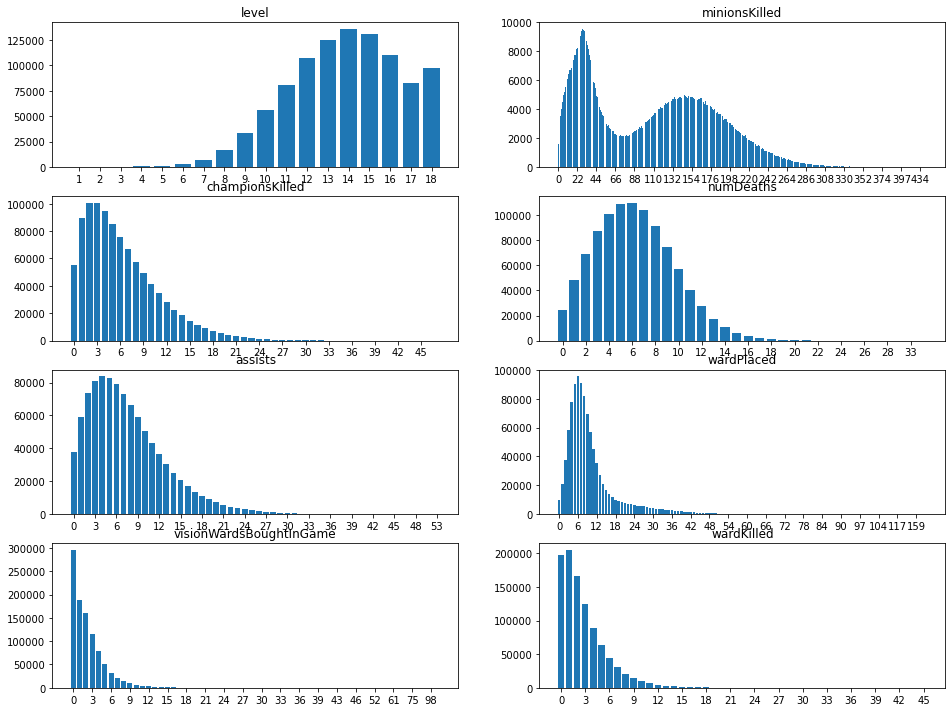

In [14]:
# 이상치 제거 전 그래프

ind = 1
plt.figure(figsize=(16,16))
plt.subplots_adjust(bottom=0.001)

for col in ['level', 'minionsKilled', 'championsKilled', 'numDeaths', 'assists', 'wardPlaced','visionWardsBoughtInGame', 'wardKilled']: 
    plt.subplot(6, 2, ind)
    plt.title(col)
    
    d = data[col]
    
    uniquelist = sorted(list(d.unique()))
    length = len(uniquelist)

    y = [0 for _ in range(length)]
    for i in range(length):
        y[i] = len(d[d == uniquelist[i]])


    x = range(len(d.unique()))
    plt.bar(x, y)
    plt.xticks(x, uniquelist)
    plt.locator_params(axis='x', nbins=20)
    ind += 1

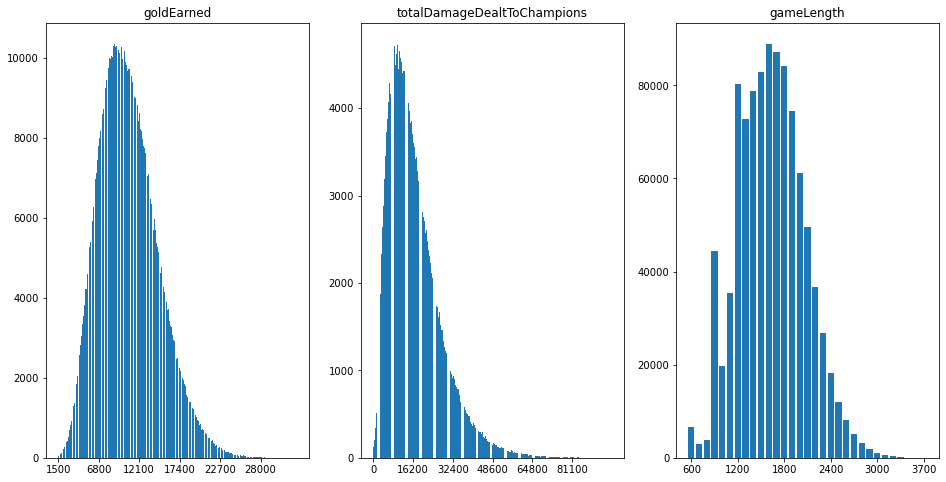

In [15]:
# 이상치 제거 전 그래프

ind = 1
plt.figure(figsize=(16, 8))

for col in ['goldEarned', 'totalDamageDealtToChampions', 'gameLength']:
    plt.subplot(1, 3, ind)
    plt.title(col)

    d = data[col]
    d = round(d//100, 2) * 100

    uniquelist = sorted(list(d.unique()))
    length = len(uniquelist)

    y = [0 for _ in range(length)]
    for i in range(length):
        y[i] = len(d[d == uniquelist[i]])


    x = range(len(d.unique()))
    plt.bar(x, y)
    plt.xticks(x, uniquelist)
    plt.locator_params(axis='x', nbins=6)
    ind += 1

In [16]:
# 위에 그래프들을 통해서 --> 이상치 제거 기준을 세울 수 있다
# level : 하위 0.3퍼 제거
# 'minionsKilled', 'championsKilled', 'numDeaths', 'assists', 'wardPlaced','visionWardsBoughtInGame', 'wardKilled' : 상위 0.3퍼 제거
# 'goldEarned', 'totalDamageDealtToChampions', 'gameLength' : 하위, 상위 0.3퍼 제거

In [17]:
# processed_data : 이상치가 제거된 데이터 

processed_data = data
want_data = ['level', 'minionsKilled', 'championsKilled', 'numDeaths', 'assists', 'wardPlaced', 'visionWardsBoughtInGame', 'wardKilled', 'goldEarned', 'totalDamageDealtToChampions', 'gameLength']
# 하위 0.3퍼, 상위 0.3퍼 데이터를 제거한다
for col in want_data:
    minimum = data[col].quantile(0.003)
    maximum = data[col].quantile(0.997)
    if col == 'level':
        processed_data = processed_data[data[col] > minimum]
    
    elif col in ['minionsKilled', 'championsKilled', 'numDeaths', 'assists', 'wardPlaced','visionWardsBoughtInGame', 'wardKilled']:
        processed_data = processed_data[data[col] < maximum]
    
    else:
         processed_data = processed_data[processed_data[col] < maximum]
         processed_data = processed_data[processed_data[col] > minimum]   

<ipython-input-17-d4ebe737dbb5>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  processed_data = processed_data[data[col] < maximum]
<ipython-input-17-d4ebe737dbb5>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  processed_data = processed_data[data[col] < maximum]
<ipython-input-17-d4ebe737dbb5>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  processed_data = processed_data[data[col] < maximum]
<ipython-input-17-d4ebe737dbb5>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  processed_data = processed_data[data[col] < maximum]
<ipython-input-17-d4ebe737dbb5>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  processed_data = processed_data[data[col] < maximum]
<ipython-input-17-d4ebe737dbb5>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  processed_data = processed_data[data[col] < maximum

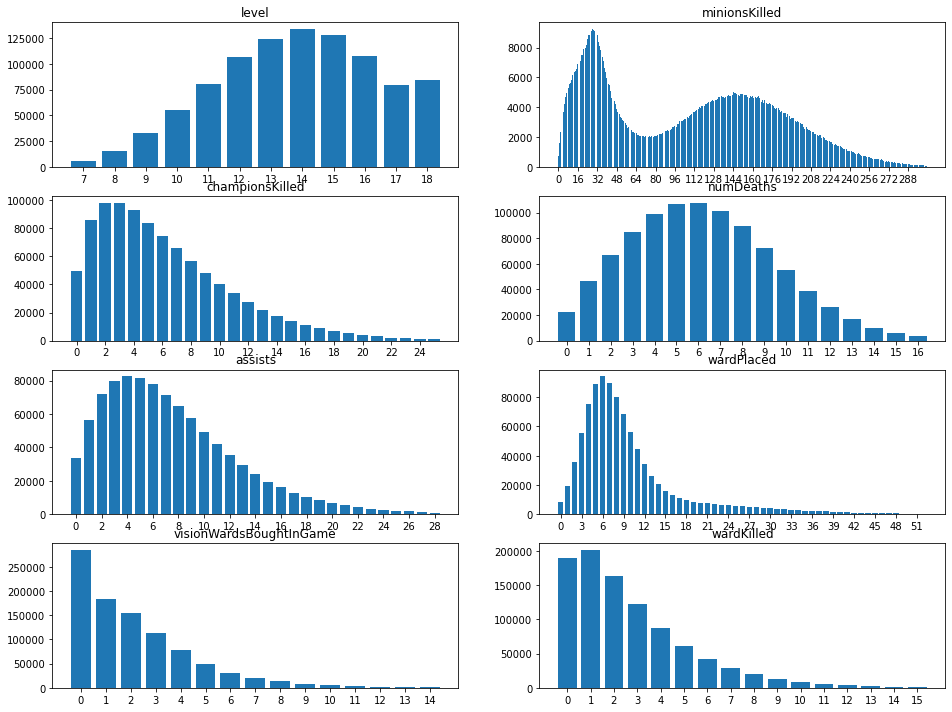

In [18]:
# 이상치 제거 후 그래프

ind = 1
plt.figure(figsize=(16,16))
plt.subplots_adjust(bottom=0.001)

for col in ['level', 'minionsKilled', 'championsKilled', 'numDeaths', 'assists', 'wardPlaced','visionWardsBoughtInGame', 'wardKilled']: 
    plt.subplot(6, 2, ind)
    plt.title(col)
    
    d = processed_data[col]
    
    uniquelist = sorted(list(d.unique()))
    length = len(uniquelist)

    y = [0 for _ in range(length)]
    for i in range(length):
        y[i] = len(d[d == uniquelist[i]])


    x = range(len(d.unique()))
    plt.bar(x, y)
    plt.xticks(x, uniquelist)
    plt.locator_params(axis='x', nbins=20)
    ind += 1

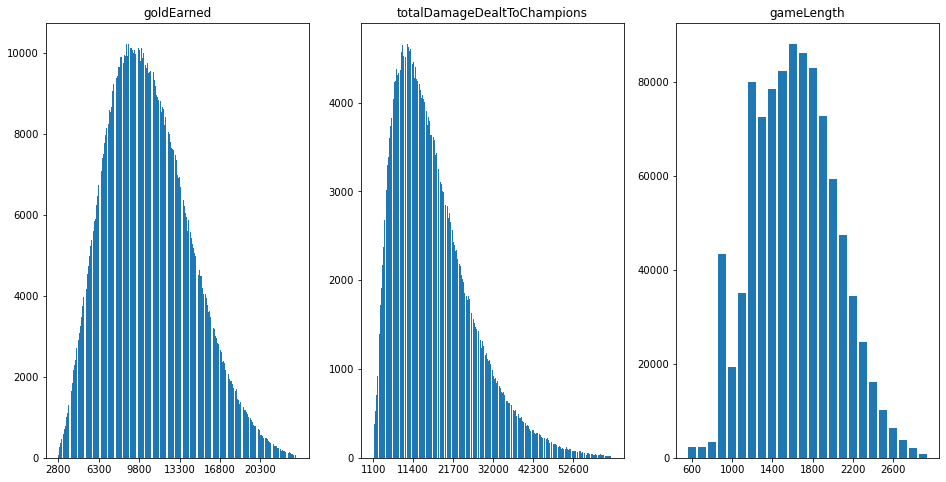

In [19]:
# 이상치 제거 후 그래프

ind = 1
plt.figure(figsize=(16, 8))

for col in ['goldEarned', 'totalDamageDealtToChampions', 'gameLength']:
    plt.subplot(1, 3, ind)
    plt.title(col)

    d = processed_data[col]
    d = round(d//100, 2) * 100

    uniquelist = sorted(list(d.unique()))
    length = len(uniquelist)

    y = [0 for _ in range(length)]
    for i in range(length):
        y[i] = len(d[d == uniquelist[i]])


    x = range(len(d.unique()))
    plt.bar(x, y)
    plt.xticks(x, uniquelist)
    plt.locator_params(axis='x', nbins=6)
    ind += 1

In [20]:
# processed_data : 이상치가 제거된 데이터의 게임시간을 60으로 나눠서 gamelength을 분당으로 계산한다.

processed_data['gameLength'] /= 60

In [21]:
# 분으로 데이터를 나눈다.

for it in processed_data.columns[4:len(processed_data.columns)-1]:
    processed_data[it] /= processed_data['gameLength']
processed_data = processed_data.drop(columns='gameLength')

In [22]:
processed_data.head(3)

,tier,division,mmr,position,level,minionsKilled,championsKilled,numDeaths,assists,wardPlaced,visionWardsBoughtInGame,wardKilled,goldEarned,totalDamageDealtToChampions
0,S,3,900.0,A,0.371134,4.206186,0.185567,0.329897,0.432990,0.247423,0.000000,0.061856,366.288660,817.402062
1,S,4,800.0,S,0.371134,1.876289,0.247423,0.061856,0.494845,0.804124,0.123711,0.247423,368.371134,1287.793814
3,S,4,800.0,M,0.371134,5.773196,0.103093,0.329897,0.164948,0.288660,0.020619,0.061856,355.546392,452.350515


In [23]:
# 확인하고 싶은 아이디 입력
# 영어로 된 아이디는 대소문자 구분해야함

summoner_name = 'qwjqonl'

In [24]:
# selenium을 백그라운드로 실행하기 위해 옵션 설정
options = webdriver.ChromeOptions()
options.add_argument('headless')
options.add_argument('window-size=1920x1080')

In [25]:
# selenium으로 실행시킬 url설정
summoner_url = 'https://poro.gg/summoner/kr/' + summoner_name
chrome_driver_path = "C:/Users/HEESU/[opgg데이터분석가]/chromedriver"
driver = webdriver.Chrome(chrome_driver_path)

driver.get(summoner_url)

<ipython-input-25-4db4e85b1dc4>:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(chrome_driver_path)


In [26]:
# 솔로랭크의 자료만을 원하므로, 솔로랭크 버튼 클릭
solo_rank_button = driver.find_element_by_css_selector("#vue-profile > div.match-history-container.mt-3 > div:nth-child(1) > div.summoner-box__content > div > div.match-history-filter__queue-types > button:nth-child(2)")
solo_rank_button.click()
time.sleep(2)

<ipython-input-26-0c252052034b>:2: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  solo_rank_button = driver.find_element_by_css_selector("#vue-profile > div.match-history-container.mt-3 > div:nth-child(1) > div.summoner-box__content > div > div.match-history-filter__queue-types > button:nth-child(2)")


In [27]:
# # 원하는 게임 숫자가 20이 넘을 경우, 이 코드를 사용하자.

# game_more_buttom = driver.find_element_by_css_selector("#vue-profile > div.match-history-container.mt-3 > button")
# game_more_buttom.click()
# time.sleep(2)

In [28]:
# 컨테이너의 정보들은, start가 3부터 시작해서, 1씩 더해지며 쌓인다.
# 각 컨테이너 마다 (+) 버튼 눌러주는 코드
start = 3
while True:
    try:
        driver.find_element_by_css_selector("#vue-profile > div.match-history-container.mt-3 > div:nth-child(" + str(start) + ") > div > div.match-history__expand-toggle").click()
        time.sleep(2)
        start += 1
    
    except Exception as e:
        pass
        break

<ipython-input-28-f85ecca347a0>:6: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_css_selector("#vue-profile > div.match-history-container.mt-3 > div:nth-child(" + str(start) + ") > div > div.match-history__expand-toggle").click()


In [29]:
# 전체 펼친 html
summoner_html = driver.page_source
summoner_soup = BeautifulSoup(summoner_html, 'html.parser')

In [30]:
driver.quit()

In [31]:
# 내 티어 정보
# my_tier, my_division : 내 티어 정보를 담는다
mysolorank_info = list(summoner_soup.select('div.summoner-tier__description'))[0]
mytier = list(mysolorank_info.stripped_strings)[0]
mylst = mytier.split('\n')

tierdict = {'아이언' : 'I', '브론즈' : 'B', '실버' : 'S', '골드' : 'G', '플래티넘' : 'P', 
 '다이아몬드' : 'D', '마스터' : 'M', '그랜드마스터' : 'R', '챌린저' : 'C'}

my_tier = tierdict[mylst[0]]
my_division = mylst[1].lstrip()
print(my_tier, my_division)

C 1


In [32]:
# 불러오는 게임의 수
# games_len = len(summoner_games_html)

summoner_games_html = summoner_soup.select('div.match-history__content')
games_len = 20

In [33]:
# 확인하고 싶은 자료 선정
Damage = []
CS = []
Wardplaced = []
visionWardplaced = []
WardKilled = []
Kill = []
Death = []
Assist = []
Level = []
Gold = []
Gamelength = []
Position = []

In [34]:
# 각각의 정보들을 각 리스트에 담아준다.

for i in range(games_len):
    Level.append(int(list(summoner_games_html[i].select_one('div.champion').stripped_strings)[0]))
    CS.append(int(list(summoner_games_html[i].select_one('div.info').stripped_strings)[3]))
    Kill.append(int(list(summoner_games_html[i].select_one('div.kda').stripped_strings)[0]))
    Death.append(int(list(summoner_games_html[i].select_one('div.kda').stripped_strings)[2]))
    Assist.append(int(list(summoner_games_html[i].select_one('div.kda').stripped_strings)[4]))
    Wardplaced.append(int(list(summoner_games_html[i].select_one(' div.wards.mt-1').stripped_strings)[1]))
    visionWardplaced.append(int(list(summoner_games_html[i].select_one(' div.wards.mt-1').stripped_strings)[0]))
    WardKilled.append(int(list(summoner_games_html[i].select_one(' div.wards.mt-1').stripped_strings)[2]))
    gl = list(summoner_games_html[i].select_one('span.mt-md-1'))[0].split(':')
    Gamelength.append(int(gl[0])*60 + int(gl[1]))

In [35]:
# 각 게임의 '자세히보기' 버튼을 눌러야 나오는 정보들을 담는 코드

summoner_results_html = summoner_soup.select('div.match-history__result')
for i in range(games_len):
    if list(summoner_results_html[i].stripped_strings)[0] == '패배':
        summoner_details_html = summoner_soup.select('div.match-history-detail__content')
        gold_selector = '#vue-profile > div.match-history-container.mt-3 > div:nth-child(' + str(i+3) + ') > div.match-history-detail > div.match-history-detail__content > div > div > div.col-12.col-lg-6.border-e6-left-md > div > div.match-detail-overview__summoners > div.match-detail-overview__summoner.match-detail-overview__summoner--me > div > div.match-detail-overview__summoner__column.stats > div.wards > div:nth-child(2) > span'
        damage_selector = '#vue-profile > div.match-history-container.mt-3 > div:nth-child(' + str(i+3) + ') > div.match-history-detail > div.match-history-detail__content > div > div > div.col-12.col-lg-6.border-e6-left-md > div > div.match-detail-overview__summoners > div.match-detail-overview__summoner.match-detail-overview__summoner--me > div > div.match-detail-overview__summoner__column.stats > div.graph > span'
        position_selector = '#vue-profile > div.match-history-container.mt-3 > div:nth-child(' + str(i+3) + ') > div.match-history-detail > div.match-history-detail__content > div > div > div.col-12.col-lg-6.border-e6-left-md > div > div.match-detail-overview__summoners'
    elif list(summoner_results_html[i].stripped_strings)[0] == '승리':
        summoner_details_html = summoner_soup.select('div.match-history-detail__content')
        gold_selector = '#vue-profile > div.match-history-container.mt-3 > div:nth-child(' + str(i+3) + ') > div.match-history-detail > div.match-history-detail__content > div > div > div:nth-child(1) > div > div.match-detail-overview__summoners > div.match-detail-overview__summoner.match-detail-overview__summoner--me > div > div.match-detail-overview__summoner__column.stats > div.wards > div:nth-child(2) > span'
        damage_selector = '#vue-profile > div.match-history-container.mt-3 > div:nth-child(' + str(i+3) + ') > div.match-history-detail > div.match-history-detail__content > div > div > div:nth-child(1) > div > div.match-detail-overview__summoners > div.match-detail-overview__summoner.match-detail-overview__summoner--me > div > div.match-detail-overview__summoner__column.stats > div.graph > span'
        position_selector = '#vue-profile > div.match-history-container.mt-3 > div:nth-child(' + str(i+3) + ') > div.match-history-detail > div.match-history-detail__content > div > div > div:nth-child(1) > div > div.match-detail-overview__summoners'
    gold = list(summoner_details_html[i].select_one(gold_selector).stripped_strings)[0]
    damage = list(summoner_details_html[i].select_one(damage_selector).stripped_strings)[0]
    
    position = ['T' ,'J', 'M', 'A', 'S']
    for j in range(5):
        if summoner_name in list(summoner_details_html[i].select_one(position_selector).stripped_strings)[17*j:17*(j+1)]:
            Position.append(position[j])
            break
            
    if gold[-1] == '천':
        g = float(gold[:-1])
        g = int(g * 1000)
        Gold.append(g)
        
    elif gold[-1] == '만':
        g = float(gold[:-1])
        g = int(g * 10000)
        Gold.append(g)
        
    if ',' in damage:
        damage = damage.replace(',', '')
    damage = int(damage)
    Damage.append(damage)
    
    time.sleep(1)

In [36]:
# mydf : 내 게임전적 데이터를 저장한 df

mydf = pd.DataFrame({'tier' : my_tier, 'division' : my_division, 'Position' : Position, 'Kill' : Kill, 'Death' : Death, 'Assist' : Assist,
                    'CS' : CS, 'Level' : Level, 'Damage' : Damage, 'Wardplaced' : Wardplaced,
                   'visionWardplaced' : visionWardplaced, 'WardKilled' : WardKilled,
                     'Gold' : Gold, 'Gamelength' : Gamelength})
mydf

,tier,division,Position,Kill,Death,Assist,CS,Level,Damage,Wardplaced,visionWardplaced,WardKilled,Gold,Gamelength
0,C,1,J,20,3,2,255,18,34359,4,3,13,21000,1852
1,C,1,J,8,1,12,128,14,16454,13,6,3,11000,1438
2,C,1,J,6,1,15,231,17,23938,6,5,6,14000,1887
3,C,1,J,17,11,14,245,18,47017,9,6,7,19000,2194
4,C,1,J,8,1,6,174,14,15765,2,1,2,12000,1416
5,C,1,J,6,5,11,124,13,15863,17,10,7,10000,1486
6,C,1,J,3,3,1,88,9,5856,1,0,5,5200,972
7,C,1,J,9,1,8,98,12,12273,1,0,1,8600,938
8,C,1,J,22,5,6,148,15,28392,7,6,7,17000,1363
9,C,1,J,3,3,2,59,8,5177,2,1,1,5100,704


In [37]:
# 내 mmr을 구하는 과정과 mmr이 추가된 mydf

for i in tierPoint.keys():
    mydf.loc[mydf['tier']==i,'mmr'] = tierPoint[i] + (4 - pd.to_numeric(mydf['division'])) * 100
my_mmr = mydf['mmr'][0]

mydf = mydf[['tier', 'division', 'mmr', 'Position', 'Kill', 'Death', 'Assist', 'CS', 'Level', 'Damage', 'Wardplaced', 'visionWardplaced', 'WardKilled', 'Gold', 'Gamelength']]
mydf

,tier,division,mmr,Position,Kill,Death,Assist,CS,Level,Damage,Wardplaced,visionWardplaced,WardKilled,Gold,Gamelength
0,C,1,3500,J,20,3,2,255,18,34359,4,3,13,21000,1852
1,C,1,3500,J,8,1,12,128,14,16454,13,6,3,11000,1438
2,C,1,3500,J,6,1,15,231,17,23938,6,5,6,14000,1887
3,C,1,3500,J,17,11,14,245,18,47017,9,6,7,19000,2194
4,C,1,3500,J,8,1,6,174,14,15765,2,1,2,12000,1416
5,C,1,3500,J,6,5,11,124,13,15863,17,10,7,10000,1486
6,C,1,3500,J,3,3,1,88,9,5856,1,0,5,5200,972
7,C,1,3500,J,9,1,8,98,12,12273,1,0,1,8600,938
8,C,1,3500,J,22,5,6,148,15,28392,7,6,7,17000,1363
9,C,1,3500,J,3,3,2,59,8,5177,2,1,1,5100,704


In [38]:
# my_processed_data : 나의 포지션별 분당 데이터

my_processed_data = mydf.groupby('Position').mean()

my_processed_data['Gamelength'] /= 60

for col in my_processed_data.columns[1:]:
    my_processed_data[col] /= my_processed_data['Gamelength']

my_processed_data = my_processed_data.drop('Gamelength', axis = 1)
my_processed_data

,mmr,Kill,Death,Assist,CS,Level,Damage,Wardplaced,visionWardplaced,WardKilled,Gold
Position,,,,,,,,,,,
J,3500.0,0.407934,0.157707,0.349057,6.756151,0.578258,937.262914,0.227097,0.140885,0.195556,509.076891
M,3500.0,0.227964,0.045593,0.410334,6.656535,0.592705,705.182371,0.136778,0.182371,0.182371,419.452888


In [39]:
my_processed_data = my_processed_data.reset_index()
my_processed_data.index = ['Me'] * len(my_processed_data)

# my_processed_data에 위에서 구한 내 티어와 division을 추가하고, 순서에 맞게 정렬한다
my_processed_data['tier'] = my_tier
my_processed_data['division'] = my_division
my_processed_data = my_processed_data[['tier', 'division', 'mmr', 'Position', 'Kill', 'Death', 'Assist', 'CS', 'Level', 'Damage', 'Wardplaced', 'visionWardplaced', 'WardKilled', 'Gold']]
my_processed_data

,tier,division,mmr,Position,Kill,Death,Assist,CS,Level,Damage,Wardplaced,visionWardplaced,WardKilled,Gold
Me,C,1,3500.0,J,0.407934,0.157707,0.349057,6.756151,0.578258,937.262914,0.227097,0.140885,0.195556,509.076891
Me,C,1,3500.0,M,0.227964,0.045593,0.410334,6.656535,0.592705,705.182371,0.136778,0.182371,0.182371,419.452888


In [40]:
# processed_data : 전체 데이터의 분당 데이터
# processed_data column의 이름과 순서를 바꾸어준다.

processed_data = processed_data.rename(columns = {'position' : 'Position',
                                'level' : 'Level',
                                'minionsKilled' : 'CS',
                                'championsKilled' : 'Kill',
                                'numDeaths' : 'Death',
                                'assists' : 'Assist',
                                'wardPlaced' : 'Wardplaced',
                                'visionWardsBoughtInGame' : 'visionWardplaced',
                                'wardKilled' : 'WardKilled',
                                'goldEarned' : 'Gold',
                                'totalDamageDealtToChampions' : 'Damage'})

processed_data = processed_data[['tier', 'division', 'mmr', 'Position', 'Kill', 'Death', 'Assist', 'CS', 'Level', 'Damage', 'Wardplaced', 'visionWardplaced', 'WardKilled', 'Gold']]

In [41]:
processed_data.head(3)

,tier,division,mmr,Position,Kill,Death,Assist,CS,Level,Damage,Wardplaced,visionWardplaced,WardKilled,Gold
0,S,3,900.0,A,0.185567,0.329897,0.432990,4.206186,0.371134,817.402062,0.247423,0.000000,0.061856,366.288660
1,S,4,800.0,S,0.247423,0.061856,0.494845,1.876289,0.371134,1287.793814,0.804124,0.123711,0.247423,368.371134
3,S,4,800.0,M,0.103093,0.329897,0.164948,5.773196,0.371134,452.350515,0.288660,0.020619,0.061856,355.546392


In [42]:
# mystat: 내가 각 포지션에서, 특정 티어 범위 안에서 상위 몇퍼센트인지 알아내는 함수
# Data에 processed_data, myData에 my_processed_data, position에 원하는 포지션, tiercnt에 원하는 mmr 범위를 넣는다.

def mystat(Data, myData, position = 'all', tierCnt = 100):
  
    # tierCnt = 1 : mytier ±1
    # tierCnt = 2 : mytier ±2

    if position != 'all':
        Data = Data[Data['Position'] == position]

    if tierCnt != 100:
        mmr = int(myData['mmr'][0])
        Data = Data[(mmr-tierCnt*100 <= Data['mmr']) & (Data['mmr'] <= mmr+tierCnt*100)]

    total = pd.concat([Data, myData])

    rankData = total.rank(ascending = False, pct = True)
    
    # 데스는 적을수록 좋으므로, ascending = True를 적용한다.
    rankData['Death'] = total['Death'].rank(ascending = True, pct = True)
    myRankData = rankData[rankData.index == 'Me']
    myRankData *= 100
    myRankData = round(myRankData, 2)
    
    myRankData = myRankData[['Kill', 'Death', 'Assist', 'CS','Level', 'Damage', 'Wardplaced', 'visionWardplaced', 'WardKilled', 'Gold']]
    return myRankData

In [43]:
# createmydf: 특정 mmr 범위를 설정하면된다. (예) 1: 주변 1티어차이.
# 전범위를 원한다 ? 100입력.

def createmydf(mmr):
    mypos = []
    for p in my_processed_data['Position']:
        mypos.append(p)

    df = pd.DataFrame()
    for pos in mypos:
        p = mystat(processed_data, my_processed_data[my_processed_data['Position'] == pos], pos, mmr)
        p.set_index([[pos]], inplace = True)
        p = p.astype(int)
        df = pd.concat([df, p])

    return df

In [44]:
# draw: 데이터를 Heatmap을 이용하여 시각화해주는 함수이다.

def draw(data):
    # annot에 들어갈 설정을 정해준다. (각 박스 안에 들어갈 내용 정해줌)
    ann = []

    lst = ['킬', '데스', '어시', 'CS', '레벨', '딜량', '와드설치', '제어와드구매', '와드제거', '골드']
    for ind in data.index:
        arr = []
        line = data[data.index == ind]
        for i in range(len(line.columns)):
            percent = line[line.columns[i]][0]
            percent = lst[i] + '\n' + '\n' + '상위 ' + str(percent) + '%'
            arr.append(percent)

        ann.append(arr)
    #==============================================
    
    # 그래프에 한글을 표기하기 위한 세팅
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
    # ==============================================
    plt.figure(figsize = (20, 4))
    sns.heatmap(data, vmin = 30, vmax = 70, annot= ann, annot_kws = {'size' : 15}, 
                xticklabels= False, yticklabels = True, linewidths = 0.5, fmt = '', cmap = 'Reds')

In [45]:
# 시각화 자료들의 상위 % 는 모두 '분당' 기준이다.
# 평균보다 좋은 성적을 거두는 지표일수록, 밝은 색이다.
# 시뻘건색일수록, 개선해야할 부분이다.
# 평균에 가까울수록, 주황색이다.

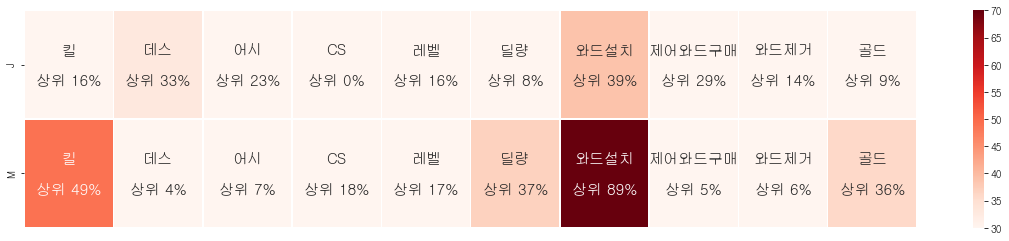

In [46]:
no_mmr_df = createmydf(100)
draw(no_mmr_df)

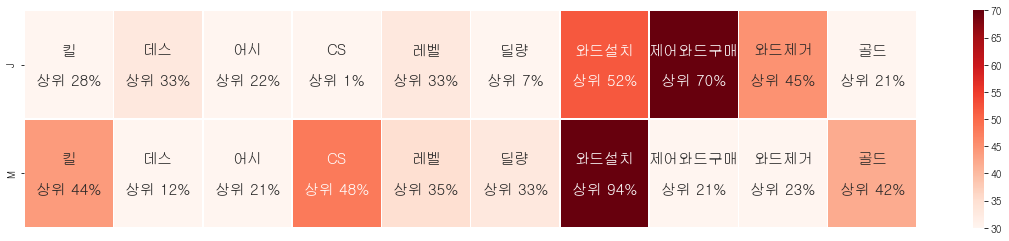

In [47]:
mmr_df = createmydf(2)
# 주변 mmr이 들어간 그래프
draw(mmr_df)

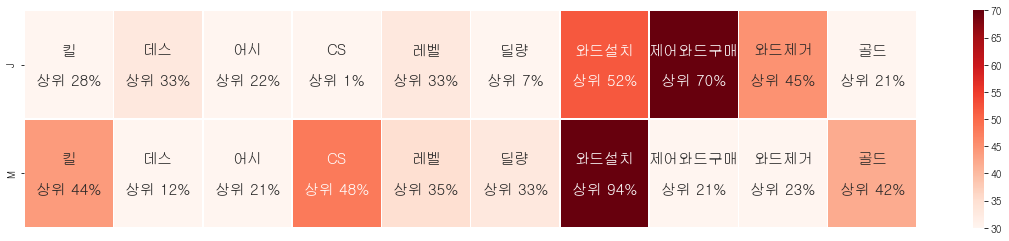

In [48]:
mmr_df = createmydf(1)
draw(mmr_df)